In [2]:
!pip install -r requirements.txt

In [8]:
import os
import warnings
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['LOKY_MAX_CPU_COUNT'] = '1'
warnings.filterwarnings('ignore')

In [10]:
def dbscan_grid_search(X_data, eps_range=np.arange(0.2, 1.5, 0.01), min_samples_range=range(3, 10)):
    best_score = -1
    best_params = {'eps': None, 'min_samples': None}
    best_labels = None
    
    for eps in eps_range:
        for min_samples in min_samples_range:
            try:
                db = DBSCAN(eps=eps, min_samples=min_samples)
                labels = db.fit_predict(X_data)

                unique_labels = np.unique(labels)
                n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
                
                if len(unique_labels) > 1:
                    score = silhouette_score(X_data, labels)
                    
                    if score > best_score:
                        best_score = score
                        best_params = {'eps': eps, 'min_samples': min_samples}
                        best_labels = labels
            except Exception as e:
                continue
                
    return best_params, best_score, best_labels


In [12]:
# Load Data & Preprocessing
df = pd.read_csv('Mall_Customers.csv')

# Encode Genre (Male=0, Female=1)
le = LabelEncoder()
df['Genre_Code'] = le.fit_transform(df['Genre'])

target = 'Spending Score (1-100)'
feats_to_compare = ['Genre_Code', 'Age', 'Annual Income (k$)']
all_feats = feats_to_compare + [target]

scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(df[all_feats])

Feature              | Best Eps   | Best MinS  | Score    | Time (s)  
---------------------------------------------------------------------------
Genre_Code           | 0.20       | 8          | 0.5812   | 2.11458
Age                  | 0.31       | 3          | 0.3776   | 1.38950
Annual Income (k$)   | 0.36       | 3          | 0.4810   | 1.46704


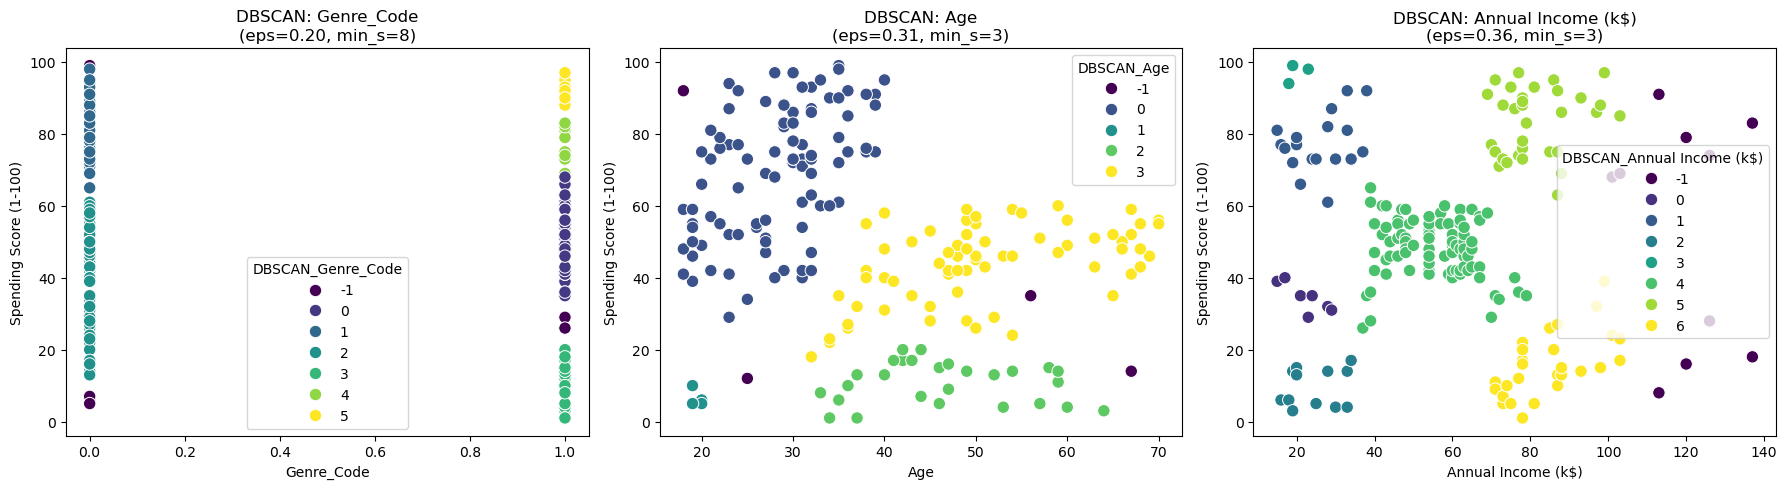

In [14]:
# DBSCAN Grid Search
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

print(f"{'Feature':<20} | {'Best Eps':<10} | {'Best MinS':<10} | {'Score':<8} | {'Time (s)':<10}")
print("-" * 75)

for i, feat in enumerate(feats_to_compare):
    # 1. Prepare Data
    X_pair = df[[feat, target]].values
    X_pair_scaled = scaler.fit_transform(X_pair)
    
    # 2. Run Grid Search & Time it
    start = time.time()
    best_params, best_score, labels = dbscan_grid_search(X_pair_scaled)
    elapsed = time.time() - start
    
    eps_val = f"{best_params['eps']:.2f}" if best_params['eps'] else "N/A"
    min_s = best_params['min_samples'] if best_params['min_samples'] else "N/A"
    
    print(f"{feat:<20} | {eps_val:<10} | {str(min_s):<10} | {best_score:.4f}   | {elapsed:.5f}")
    
    if labels is not None:
        cluster_col = f'DBSCAN_{feat}'
        df[cluster_col] = labels
        
        # Determine palette size (clusters + noise)
        unique_labels = np.unique(labels)
        palette = sns.color_palette('viridis', len(unique_labels))
        
        sns.scatterplot(x=df[feat], y=df[target], hue=df[cluster_col], 
                        palette='viridis', ax=axes[i], legend='full', s=80)
        axes[i].set_title(f'DBSCAN: {feat}\n(eps={eps_val}, min_s={min_s})')
    else:
        axes[i].set_title(f'DBSCAN: {feat}\n(No valid clusters found)')

plt.tight_layout()
plt.show()


Global Result | eps=1.08 | min_s=3 | Score=0.2776 | Time=2.1167s


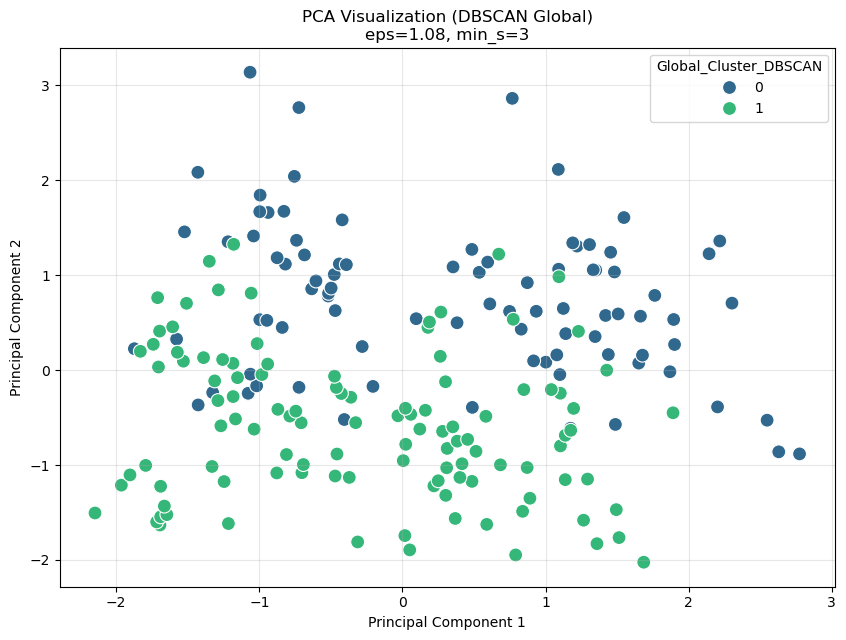

In [16]:
#Global DBSCAN & PCA
start = time.time()
best_params_global, best_score_global, labels_global = dbscan_grid_search(X_all_scaled)
elapsed = time.time() - start

print(f"Global Result | eps={best_params_global['eps']:.2f} | min_s={best_params_global['min_samples']} | Score={best_score_global:.4f} | Time={elapsed:.4f}s")

# PCA 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all_scaled)

df['PCA_1'] = X_pca[:, 0]
df['PCA_2'] = X_pca[:, 1]
df['Global_Cluster_DBSCAN'] = labels_global

plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA_1', y='PCA_2', hue='Global_Cluster_DBSCAN', data=df, palette='viridis', s=100)
plt.title(f'PCA Visualization (DBSCAN Global)\neps={best_params_global["eps"]:.2f}, min_s={best_params_global["min_samples"]}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, alpha=0.3)
plt.show()